In [1]:
% load_ext rpy2.ipython

In [2]:
%%R
#ip <- installed.packages() 
#pkgs.to.remove <- ip[!(ip[,"Priority"] %in% c("base", "recommended")), 1]
#sapply(pkgs.to.remove, remove.packages)

NULL


In [3]:
%%R
#source("http://bioconductor.org/biocLite.R")
#biocLite("phyloseq")

NULL


In [2]:
%%R
library("phyloseq")
library(ggplot2)

In [3]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/trees/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
physeq = ps.merged

In [5]:
%%R
ps.b = subset_taxa(physeq,Kingdom=="Bacteria")
ps.b = subset_samples(ps.b,sample_sums(physeq)>3000)

In [80]:
%%R
physeq.noSmall<-subset_samples(physeq,sample_sums(physeq)>1500)

In [16]:
%%R
physeq.2.5.noSmall<-subset_samples(physeq.noSmall, Month==2.5)

In [22]:
%%R
physeq.2.5<-subset_samples(physeq, Month==2.5)

In [81]:
%%R
ps <- physeq.noSmall

In [82]:
%%R
# Normalizes the sample counts by the total - i.e., reporting what fraction of each sample each OTU makes up.
ps_snorm = transform_sample_counts(ps, function(x) x / sum(x))

In [85]:
%%R
# Computing the Bray distance matrix and NMDS in parallel

ord.full = ordinate(ps_snorm, method = "NMDS", distance = "bray", weighted=TRUE, k=3, trymax=40)
# Consider trymax= and k=3

Run 0 stress 0.08815468 
Run 1 stress 0.08665463 
... New best solution
... procrustes: rmse 0.04030066  max resid 0.2481345 
Run 2 stress 0.08644497 
... New best solution
... procrustes: rmse 0.009520936  max resid 0.04565446 
Run 3 stress 0.08644661 
... procrustes: rmse 0.003106427  max resid 0.01329334 
Run 4 stress 0.08799907 
Run 5 stress 0.08988609 
Run 6 stress 0.08645068 
... procrustes: rmse 0.003513669  max resid 0.01527671 
Run 7 stress 0.08644486 
... New best solution
... procrustes: rmse 0.00278488  max resid 0.01181969 
Run 8 stress 0.09541516 
Run 9 stress 0.08799141 
Run 10 stress 0.09822681 
Run 11 stress 0.08807816 
Run 12 stress 0.08800362 
Run 13 stress 0.09773261 
Run 14 stress 0.08988827 
Run 15 stress 0.08820792 
Run 16 stress 0.08644429 
... New best solution
... procrustes: rmse 0.00314669  max resid 0.0143873 
Run 17 stress 0.08799205 
Run 18 stress 0.08644836 
... procrustes: rmse 0.003686187  max resid 0.01548652 
Run 19 stress 0.08814839 
Run 20 stress 0

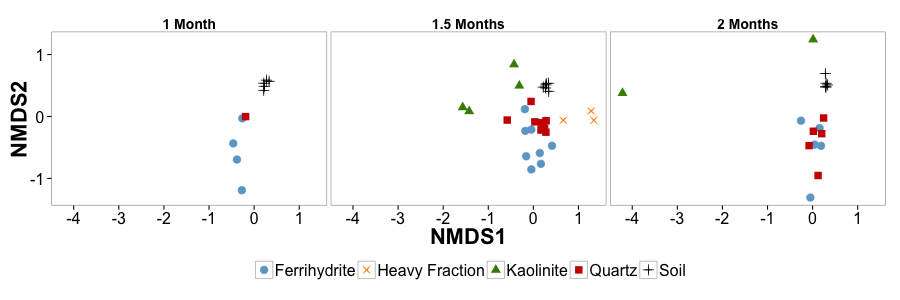

In [86]:
%%R -h 300 -w 900
D <- ord.full
# Sets the relevant ordination

sample_data(ps_snorm)$Cosm=as.factor(sample_data(ps_snorm)$Cosm)
sample_data(ps_snorm)$Month=as.factor(sample_data(ps_snorm)$Month)
sample_data(ps_snorm)$MonthName=ifelse(sample_data(ps_snorm)$Month==2.0,"1 Month", ifelse(sample_data(ps_snorm)$Month==2.5,"1.5 Months","2 Months"))

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = plot_ordination(ps_snorm, D, color = "Trtmt", shape = "Trtmt", axes=c(1,2))

# Determines the size of the symbols
p = p  + geom_point(size=3.5) + scale_colour_manual(values=c("skyblue3","darkorange","chartreuse4","red3","black","gold1"))

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))
p = p + scale_shape_manual(values=c(19,4,17,15,3))

p = p + scale_x_continuous(breaks=c(-4,-3,-2,-1,0,1))
p = p + scale_y_continuous(breaks=c(-1,0,1))

p = p + theme_bw() +
  theme(
      legend.position = "bottom",
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
    ,strip.text.x = element_text(size=14, face="bold"),
        axis.title = element_text(size=22, face="bold"),
        axis.text = element_text(size=16),
        legend.text = element_text(size=16),
        legend.title = element_text(size = 22),
        strip.background = element_rect(colour="white", fill="white"))

p = p + facet_grid(~MonthName)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days

p

In [87]:
%%R
ggsave(filename="NMDS-16S-3month.jpg", plot=p ,width=8.5, height=4)

I need to calculate similarity distances between all units and see if the values are closer for related microcosms.  
See Soil_Effect notebook. There is not a significant difference detected.

Error in { : task 367 failed - "Interrupted"
In addition: Warning message:
In UniFrac(physeq, ...) :
  Randomly assigning root as -- 58_179884 -- in the phylogenetic tree in the data you provided.
Square root transformation
Wisconsin double standardization
Run 0 stress 0.09380201 
Run 1 stress 0.09445325 
Run 2 stress 0.09523874 
Run 3 stress 0.09418401 
... procrustes: rmse 0.01205185  max resid 0.06188465 
Run 4 stress 0.09380017 
... New best solution
... procrustes: rmse 0.0002785023  max resid 0.001598697 
*** Solution reached


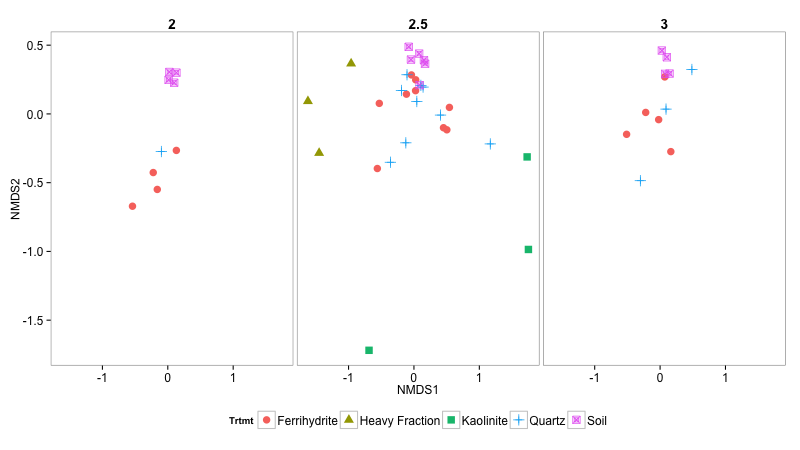

In [19]:
%%R -h 450 -w 800
# Computing the Bray distance matrix and NMDS in parallel

#ps = prune_samples(sample_data(ps_snorm)$Trtmt=="Soil"|sample_data(ps_snorm)$Trtmt=="Ferrihydrite", ps_snorm)

ord.full = ordinate(ps, method = "NMDS", distance = "bray", weighted=TRUE, k=3, trymax=40)
# Consider trymax= and k=3

D <- ord.full
# Sets the relevant ordination

sample_data(ps)$Cosm=as.factor(sample_data(ps)$Cosm)
sample_data(ps)$Month=as.factor(sample_data(ps)$Month)

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = plot_ordination(ps, D, color = "Trtmt", shape = "Trtmt", axes=c(1,2))

# Determines the size of the symbols
p = p  + geom_point(size=3.5) 

p = p + guides(color = element_blank(), shape = element_blank())

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
      legend.position = "bottom"
    ,plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),axis.text = element_text(size=12),legend.text = element_text(size=12),
          strip.background = element_rect(colour="white", fill="white"))

p = p + facet_grid(~Month)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days

p